In [7]:
import os, glob, sys
import time
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm

import nibabel as nib
from nilearn import plotting, masking, image, datasets

from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix

%matplotlib inline 

In [2]:
MODEL_NAME = 'pmod_pop_rank'
GROUP_DIR = '/data00/projects/megameta/group_models/'
output_dir = os.path.join(GROUP_DIR, 'custom', 'model_2nd-level_lm-{}'.format(MODEL_NAME))
os.makedirs(output_dir, exist_ok=True)

In [3]:
root_dir = '/data00/projects/megameta'

datasource = {
'Movietrailers': 'rsm_movietrailer/derivatives/nipype/model_MOVIE_pmod_pop_rank',
'TVC': 'rsm_tvc35/derivatives/nipype/model_TVC_pmod_pop_rank',
'DARPA': 'darpa1/derivatives/nipype/model_SHARE_pmod_pop_rank',
'CityYear': 'cityyear/derivatives/nipype/model_MESSAGE_pmod_pop_rank',
'Alcohol': 'alcohol/derivatives/nipype/model_TASK_pmod_pop_rank',
'Stanford': 'stanford_041320/derivatives/nipype/model_WATCH_pmod_pop_rank',
'Project1': 'project1/derivatives/nipype/model_BANNER_IMAGE_pmod_pop_rank' }

In [4]:
if os.path.exists('contrast_list.csv'):
    contrast_df = pd.read_csv('contrast_list.csv')
else:
    contrast_list = []

    for study, study_path in datasource.items():
        print(f"Scanning {study}...", end = " ")
        con_files = glob.glob(os.path.join(root_dir, study_path, '*/*/*/con*.nii'))
        print(f"{len(con_files)} contrasts found.")

        for cf in con_files:
            description = nib.load(cf).header['descrip'].tolist().decode('utf-8')
            cf_parts = cf.split('/')

            entry = {
                'study': study,
                'subj': cf_parts[-4],
                'resolution': cf_parts[-3],
                'fwhm': cf_parts[-2],
                'path': cf,
                'contrast': description.split(": ")[-1],           
            }
            contrast_list.append(entry)
            print("*",end="")
        print("")
    
    contrast_df = pd.DataFrame(contrast_list)
    contrast_df.to_csv('contrast_list.csv',index=False)

In [5]:
contrast_df.groupby(['contrast','study']).describe().loc[:,('subj','count')]

contrast                                study        
constant                                Alcohol          56
                                        CityYear         39
                                        DARPA            41
                                        Movietrailers    25
                                        Project1         48
                                        Stanford         40
                                        TVC              59
impure_message                          Alcohol          56
                                        DARPA            41
impure_messagexint_pop_rank^1           Alcohol          56
impure_messagexpmod_pop_retrans_rank^1  DARPA            41
non_message_event                       Alcohol          56
                                        CityYear         39
                                        DARPA            41
                                        Movietrailers    25
                                        Projec

In [6]:
included_contrasts = ['pure_messagexint_pop_rank^1',
                      'pure_messagexpmod_pop_ctrmean_rank^1',
                      'pure_messagexpmod_pop_rank^1',
                      'pure_messagexpmod_pop_retrans_rank^1',
                      'pure_messagexpopulation_CTR_rank^1' ]

In [8]:
included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]
print(f"Duplicates: {included_df.duplicated(subset=['study','subj']).sum()}")

Duplicates: 0


In [9]:
included_df.study.value_counts()

TVC              59
Alcohol          56
Project1         48
DARPA            41
Stanford         40
CityYear         39
Movietrailers    25
Name: study, dtype: int64

In [18]:
#mask = '/data00/tools/spm8/apriori/brainmask_th25.nii'
mask = image.math_img('np.sign(img)', img=datasets.fetch_atlas_aal().maps)

template = '/data00/projects/megameta/templates/reference_medium_wad.nii'

mask = image.resample_to_img(mask, template, interpolation='linear')

In [11]:
nsamples = len(included_df)

## Intercept only

Not controlling for study.

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


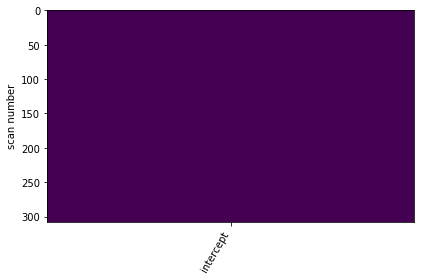

In [13]:
design_matrix = pd.DataFrame({'intercept': [1] * nsamples})
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


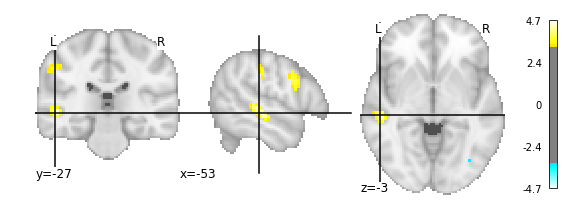

In [14]:
thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")
z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_intercept_only.nii.gz'))

Cluster robust regression

In [104]:
def cluster_regression(signals, exog, groups):

    nfeatures = signals.shape[1]
    nsamples = signals.shape[0]
    nregressors = exog.shape[1]

    cluster_ids = pd.Categorical(included_df.study).codes

    z_maps = np.zeros((nregressors, nfeatures))

    for idx in range(nfeatures):

        endog = signals[:, idx]

        if np.all(endog == np.mean(endog)):
            continue

        model = sm.OLS(endog, exog)
        results = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

        z_maps[:, idx] = results.tvalues
    
    return z_maps

In [105]:
def fdr_threshold(z_maps, threshold=0.05):
    from statsmodels.stats.multitest import multipletests
    
    fdr_thres = []
    
    for zm in z_maps:
        p_map = sp.stats.norm.sf(zm) * 2
        
        reject, _, _, _ = multipletests(p_map, alpha=threshold, method='fdr_bh')
        
        if np.any(reject):
            fdr_thres.append(np.nanmin(np.abs(zm[reject])))
        else:
            fdr_thres.append(np.nan)
            
    return fdr_thres

In [72]:
signals = masking.apply_mask(included_df.path.values.tolist(), mask)

In [106]:
cluster_ids = pd.Categorical(included_df.study).codes
exog = design_matrix.values

z_maps = cluster_regression(signals, exog, cluster_ids)

In [107]:
fdr_thres = fdr_threshold(z_maps, 0.05)

In [108]:
thres = np.abs(sp.stats.norm.ppf(0.001 / 2))

In [114]:
masking.unmask(z_maps[0],mask).to_filename('cluster_robust.nii.gz')

In [119]:
from nistats import reporting
tab = reporting.get_clusters_table(masking.unmask(z_maps[0],mask), thres, min_distance=200)
tab = tab.sort_values(by="Cluster Size (mm3)", ascending=False)

In [120]:
tab

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
4,5,6.0,-61.0,-41.0,4.403172,918
1,2,-36.0,-82.0,-38.0,4.960395,729
5,6,21.0,-67.0,-50.0,4.378553,405
2,3,3.0,29.0,52.0,4.894512,216
7,8,-27.0,-61.0,-41.0,4.022088,216
9,10,57.0,5.0,19.0,3.889142,189
8,9,-15.0,-73.0,-23.0,3.979047,135
25,26,12.0,-16.0,7.0,3.403732,108
24,25,57.0,23.0,16.0,3.467155,108
12,13,27.0,-61.0,-47.0,3.710304,108


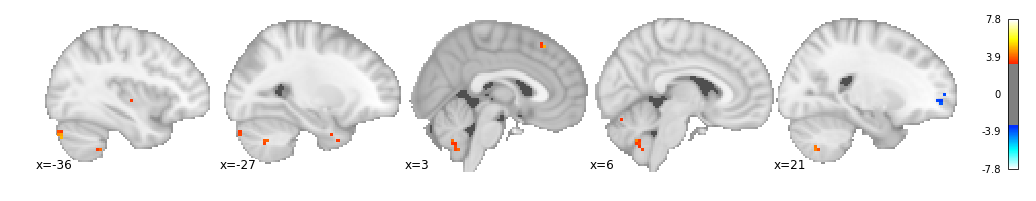

In [121]:
plotting.plot_stat_map(masking.unmask(z_maps[0],mask), threshold=thres, display_mode='x', cut_coords=tab.X.values[:5])

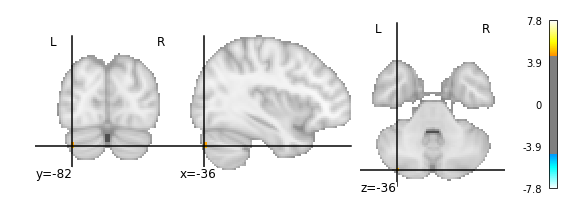

In [111]:
plotting.plot_stat_map(masking.unmask(z_maps[0],mask), threshold=fdr_thres[0])

## Health and marketing

In [69]:
z_maps = np.zeros((exog.shape[1], nfeatures))

for idx in range(nfeatures):
    
    if (nan_mask[nfeature]):
        continue
        
    endog = signals[:, idx]
        
    model = sm.OLS(endog[signal_mask], exog[signal_mask,:])
    results = model.fit(cov_type='cluster', cov_kwds={'groups': cluster_ids[signal_mask]})

    z_maps[:, idx] = results.tvalues

In [53]:
p_maps = []
for zm in z_maps:
    pm = sp.stats.norm.sf(zm) * 2
    p_maps = 
reject, p_fdr, _, _ = multipletests(p_map[~np.isnan(p_map)], alpha=0.05, method='fdr_bh')

-5.430515089870609

In [55]:
from statsmodels.stats.multitest import multipletests 
reject, p_fdr, _, _ = multipletests(p_map[~np.isnan(p_map)], alpha=0.05, method='fdr_bh')

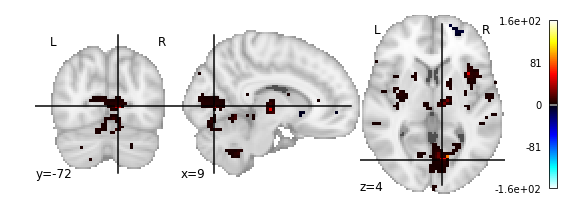

In [70]:
p_thres = .001
threshold = sp.stats.norm.isf(p_thres/2)

plotting.plot_stat_map(masking.unmask(z_maps, mask), threshold=threshold)

In [67]:
(z_maps == 0).sum()

668

In [ ]:
sp.stats.norm.sf(2.439) * 2

In [ ]:
plotting.new

In [61]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']
signal_mask = included_df.study.isin(marketing_studies).values

In [68]:
health_studies = ['Alcohol', 'Project1', 'DARPA']
signal_mask = included_df.study.isin(health_studies).values


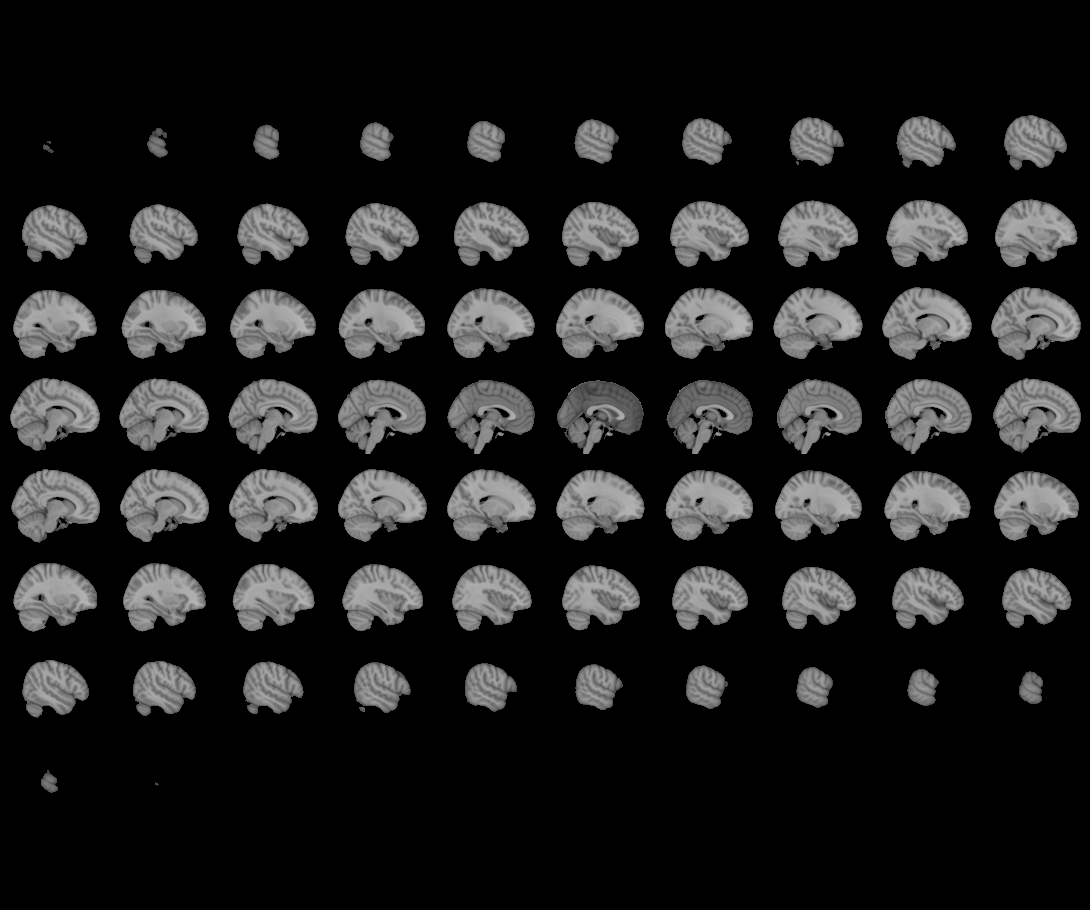
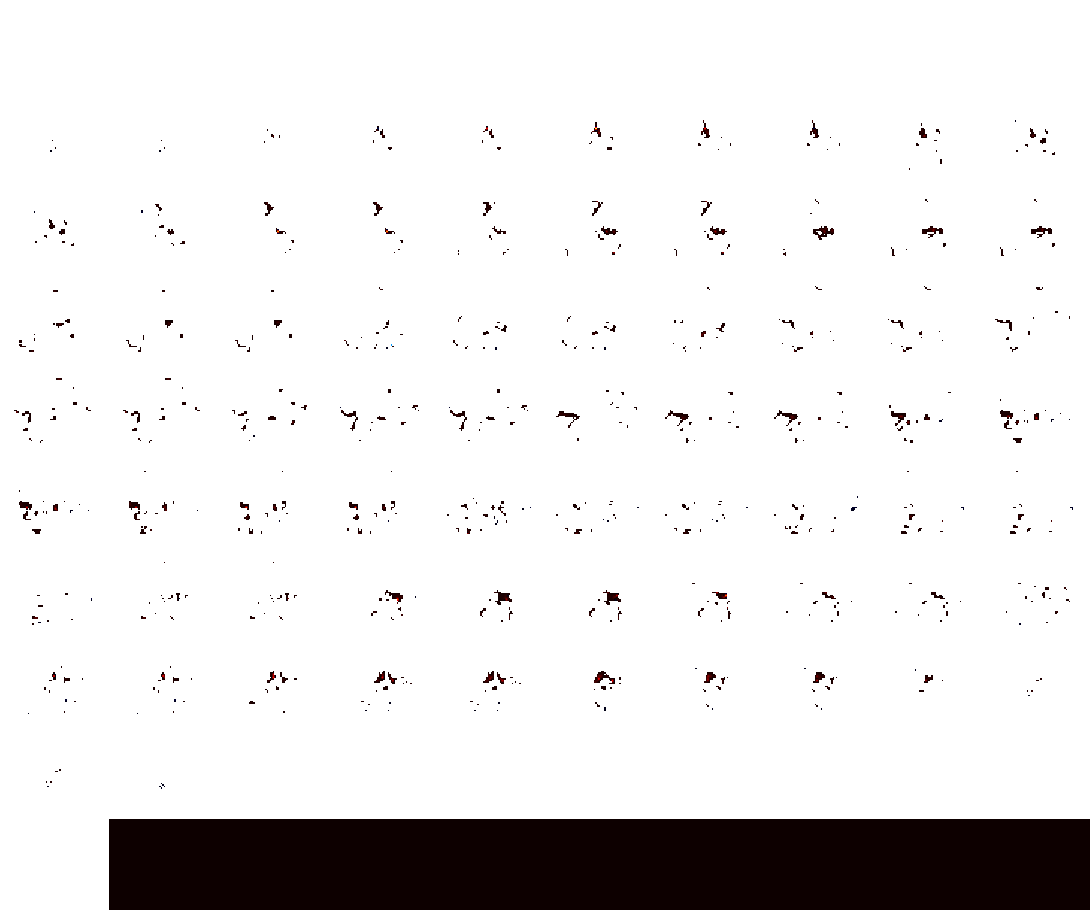

In [71]:
plotting.view_img(masking.unmask(z_maps, mask), threshold=threshold)

In [17]:
plotting.plot_roi(mask)

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
MultiNiftiMasker(d...

In [ ]:
signals = masking.apply_mask(included_df.path.values.tolist(), mask)

In [15]:
z = masking.apply_mask(z_map, mask)

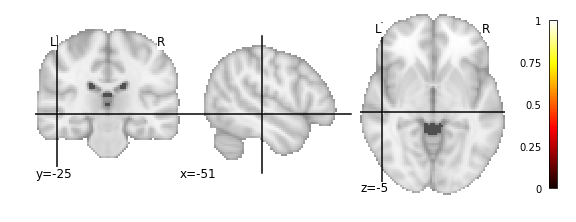

In [19]:
plotting.plot_stat_map(masking.unmask(z == np.max(z), mask))

In [18]:
np.where(z == np.max(z))

(array([52505]),)

In [20]:
all_signals = masking.apply_mask(included_df.path.values.tolist(), mask)

In [21]:
all_signals.shape

(308, 56375)

In [23]:
np.max(z)

4.7127988367913645

In [24]:
a = second_level_model.compute_contrast('intercept', output_type='all')

In [26]:
for key,img_map in a.items():
    print(key, masking.apply_mask(img_map,mask)[52505])

z_score 4.7127988367913645
stat 4.803365263378784
p_value 1.2216868811224404e-06
effect_size 0.005885313770421191
effect_variance 1.5012327064987167e-06


In [57]:
%timeit results = model.fit(cov_type='cluster', use_correction=True, df_correction=True, cov_kwds={'groups': pd.Categorical(included_df.study).codes})

892 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
model.fit().summary()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Fri, 22 May 2020   Prob (F-statistic):                nan
Time:                        10:04:57   Log-Likelihood:                 746.05
No. Observations:                 308   AIC:                            -1490.
Df Residuals:                     307   BIC:                            -1486.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.001      4.803      0.000       0.003       0.008
==============================================================================
Omnibus:                       76.915   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1707.114
Skew:                           0.323   Prob(JB):                         0.00
Kurtosis:                      14.515   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
results.tvalues

array([2.4393687])

In [21]:
results = model.fit(cov_type='cluster', use_correction=True, df_correction=True, cov_kwds={'groups': pd.Categorical(included_df.study).codes})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 May 2020   Prob (F-statistic):                nan
Time:                        10:04:46   Log-Likelihood:                 746.05
No. Observations:                 308   AIC:                            -1490.
Df Residuals:                     307   BIC:                            -1486.
Df Model:                           0                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.439      0.015       0.001       0.011
==============================================================================
Omnibus:                       76.915   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1707.114
Skew:                           0.323   Prob(JB):                         0.00
Kurtosis:                      14.515   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

0.014727968256939531

In [61]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_params_default',
 'cov_type',
 'df_model',
 'df_resid',
 'df_resid_inference',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_co

In [60]:
results.cov_params()

array([[5.82082242e-06]])

In [20]:
model = sm.OLS(signals[:,52505], np.ones(len(signals)).reshape((len(signals),1)))

In [47]:
new_results = results.get_robustcov_results(cov_type='cluster', use_correction=True, df_correction=True, groups=pd.Categorical(included_df.study).codes)
new_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 May 2020   Prob (F-statistic):                nan
Time:                        09:43:06   Log-Likelihood:                 746.05
No. Observations:                 308   AIC:                            -1490.
Df Residuals:                     307   BIC:                            -1486.
Df Model:                           0                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.439      0.015       0.001       0.011
==============================================================================
Omnibus:                       76.915   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1707.114
Skew:                           0.323   Prob(JB):                         0.00
Kurtosis:                      14.515   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

In [51]:
import statsmodels.api as sm

model = sm.OLS(all_signals[:,52505], np.ones(len(all_signals)).reshape((len(all_signals),1)))
#model = sm.OLS(np.zeros(len(all_signals)), np.ones(len(all_signals)).reshape((len(all_signals),1)))
results = model.fit()
results.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:47: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 May 2020   Prob (F-statistic):                nan
Time:                        09:48:10   Log-Likelihood:                    inf
No. Observations:                 308   AIC:                              -inf
Df Residuals:                     307   BIC:                              -inf
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
==============================================================================
Omnibus:                      995.800   Durbin-Watson:                     nan
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.500
Skew:                           0.000   Prob(JB):                     8.31e-26
Kurtosis:                       0.000   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Study fixed effects

Controlling for study but still looking at grand mean

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


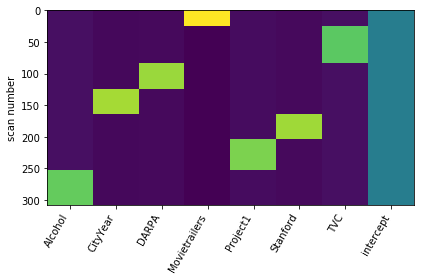

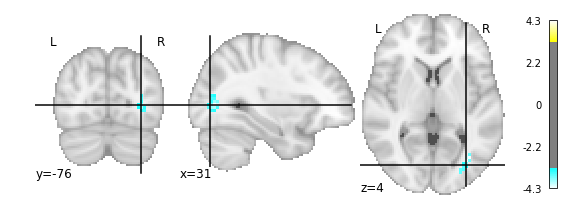

In [16]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects.nii.gz'))

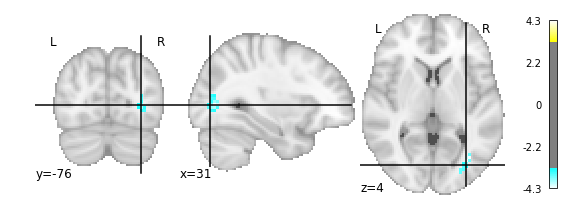

In [17]:
plotting.plot_stat_map(z_map, threshold=3.29)

## Marketing vs Health

In [18]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']
health_studies = ['Alcohol', 'Project1', 'DARPA']

#leaving out cityyear here

Health (as intercept)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 4.498


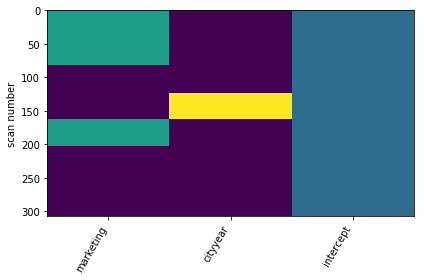

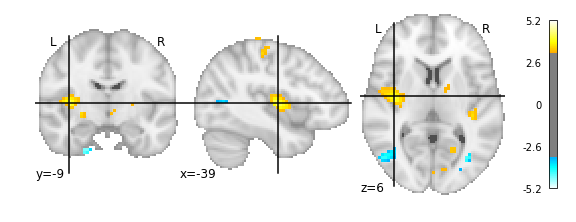

In [16]:
design_matrix = pd.DataFrame()
design_matrix['marketing'] = included_df.study.isin(marketing_studies).astype(int)
design_matrix['cityyear'] = (included_df.study == 'CityYear').astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_health_intercept.nii.gz'))

Marketing (as intercept)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 3.911


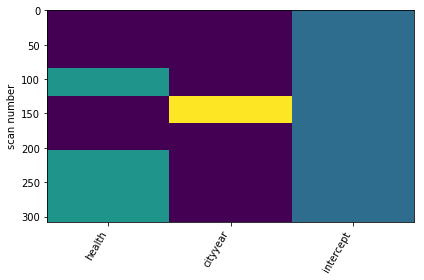

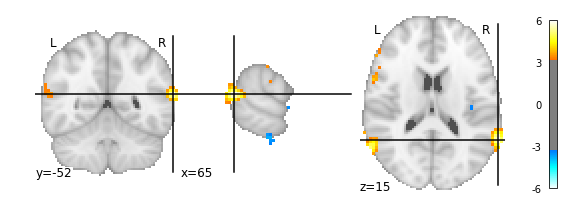

In [19]:
design_matrix = pd.DataFrame()
design_matrix['health'] = included_df.study.isin(health_studies).astype(int)
design_matrix['cityyear'] = (included_df.study == 'CityYear').astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_marketing_intercept.nii.gz'))

Difference map (Health > Marketing)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 3.598


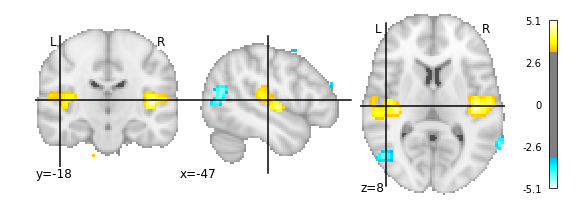

In [20]:
z_map = second_level_model.compute_contrast('health', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

## Marketing vs Health with study fixed effects (?????)

In [1]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']

In [2]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['marketing'] = included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_health_intercept.nii.gz'))

NameError: name 'pd' is not defined

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


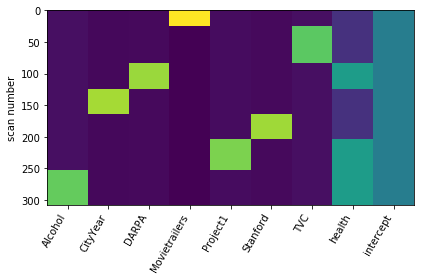

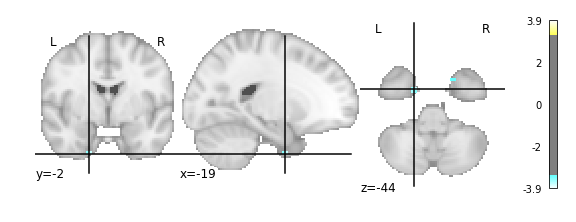

In [150]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['health'] = 1 - included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_marketing_intercept.nii.gz'))